In [1]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.linear_model import Ridge
from sklearn import svm
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import StratifiedKFold
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Objectve
## Build SVM to categorize Strain,Stress,Medium, and GenePerturbation
# KR
## 1. Feature Selection using Ridge Regression
## 2. Plot ROC and PR Curve for each classifier

In [2]:
df = pd.read_csv('ecs171.dataset.txt', sep='\s')
print(df.columns)

Index(['ID', 'Strain', 'Medium', 'Stress', 'GenePerturbed', 'GrowthRate',
       'b3356', 'b2922', 'b2519', 'b3823',
       ...
       'b4673', 'b4684', 'b4689', 'b4685', 'b4683', 'b4682', 'b4699', 'b4698',
       'b4704', 'b4703'],
      dtype='object', length=4501)


In [4]:
#Get Features and labels
X = df.iloc[:,6:].values
Strain = df.Strain
Medium = df.Medium
Stress = df.Stress
GenePerturbed = df.GenePerturbed

In [5]:
#Convert Labels to integer values
def convert_to_int(Y):
    Y_int = np.empty(Y.shape)
    labels = Y.unique()
    m = Y.shape[0]
    for idx, i in enumerate(labels):
        for j in range(m):
            if Y.iloc[j] == i:
                Y_int[j]= idx
    Y_int = np.reshape(Y_int, [194,1])     
    return Y_int

In [6]:
#Convert all values to ints
Strain_int = convert_to_int(Strain)
Stress_int = convert_to_int(Stress)
Medium_int = convert_to_int(Medium)
GenePerturbed_int = convert_to_int(GenePerturbed)


In [7]:
#Load coefficients from Ridge Regression for features selection
coef_ridge = np.load('coef_ridge.npy')

In [8]:
#Initialize list and append index with zeros-coefficient
zero_coef = []
for idx, i in enumerate(coef_ridge):
    if i ==0:
        zero_coef.append(idx)
    

In [9]:
X_new = (np.delete(X,zero_coef, axis= 1))   #Remove all features with zero-coefficient from Ridge Regression


In [10]:
#Convert labels to one hot encodings
def binarize_labels(Y):
    unique = np.unique(Y)
    return label_binarize(Y, classes = unique)

In [11]:
#Define folds
cv = StratifiedKFold(n_splits=10)

In [12]:
#Define function to generate ROC Curve
def ROC_Curve(X,Y,name):
    one_hot = binarize_labels(Y)  #Binarize Labels
    preds = []  #initialize list to hold predictions
    true = []   #initialize list to hold true values
    cv = StratifiedKFold(n_splits=10)   #Define Number of splits
    for train, test in cv.split(X,Y):   #Find train,test index
        classifier = OneVsRestClassifier(svm.SVC(kernel='linear', C=1))  #Initialize classifier with linear kernel
        predict = classifier.fit(X[train], one_hot[train]).predict(X[test])  #Fit and predict
        preds.extend(predict.ravel().tolist())   #Flatten Predictions and append to initial list
        true.extend(one_hot[test].ravel().tolist())   #Flatten True values and append to initial list
    fpr, tpr, _ = roc_curve(true, preds)    #Find FPR, TPR
    roc_auc = auc(fpr, tpr)  #Find AUC
    #Plot figure
    plt.figure()
    plt.plot(fpr, tpr,
             label='ROC curve (area = {0:0.2f})'''.format(roc_auc), linewidth=2)

    plt.plot([0, 1], [0, 1], 'k--',)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.grid()
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve for {}'.format(name))
    plt.legend(loc="lower right")
    plt.show()
    

In [13]:
#Define function to find Precision Recall Curve
def PR_Curve(X,Y,name):
    one_hot = binarize_labels(Y)
    preds = []
    true = []
    cv = StratifiedKFold(n_splits=10)
    for train, test in cv.split(X,Y):
        classifier = OneVsRestClassifier(svm.SVC(kernel='linear', C=1))
        predict = classifier.fit(X[train], one_hot[train]).predict(X[test])
        preds.extend(predict.ravel().tolist())
        true.extend(one_hot[test].ravel().tolist())
    precision, recall, _ = precision_recall_curve(true, preds)
    pr_auc = auc(recall, precision)
    plt.figure()
    plt.plot(recall, precision,
             label='PR curve (area = {0:0.2f})'''.format(pr_auc), linewidth=2)

    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.grid()
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('PR curve for {}'.format(name))
    plt.legend(loc="lower right")
    plt.savefig('PR{}.pdf'.format(name))
    plt.show()
    

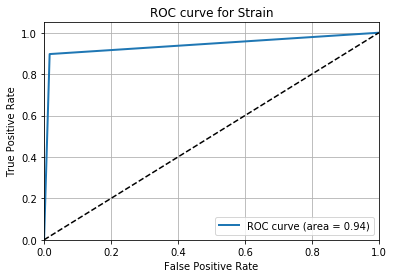

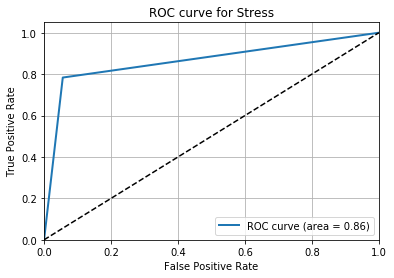

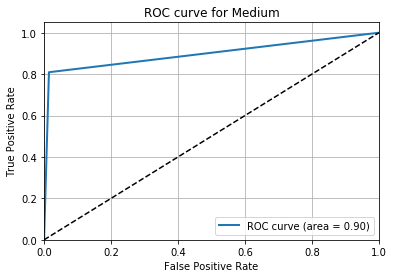

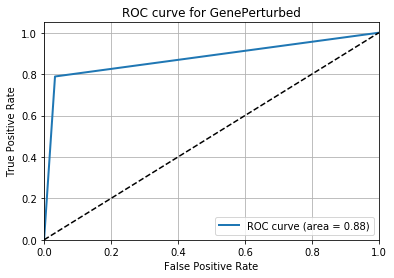

In [14]:
ROC_Curve(X_new,Strain_int, 'Strain')
ROC_Curve(X_new,Stress_int, 'Stress')
ROC_Curve(X_new, Medium_int, 'Medium')
ROC_Curve(X_new, GenePerturbed_int, 'GenePerturbed')

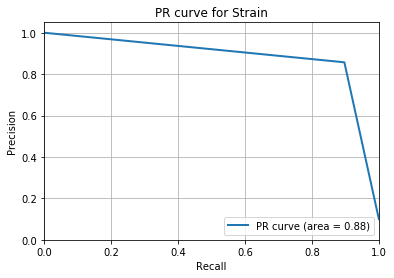

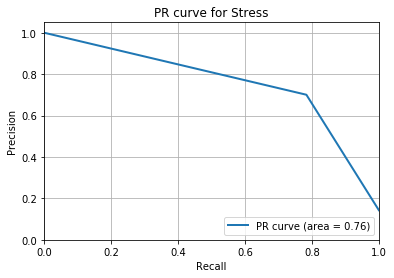

In [ ]:
PR_Curve(X_new,Strain_int, 'Strain')
PR_Curve(X_new,Stress_int, 'Stress')
PR_Curve(X_new, Medium_int, 'Medium')
PR_Curve(X_new, GenePerturbed_int, 'GenePerturbed')